# Dynamics, Networks and Computation 67562

# Homework Exercise 2   

Gal Cesana 318510633

## 2 Fluctuations in Growth

### 2.1 Behavior of The mean


The stochastic birth-only process has the following dynamics for the mean population size $\langle N(t)\rangle$:

\begin{align*}
\frac{d\langle N(t)\rangle}{dt} &= \mu\, \langle N(t)\rangle, &\langle N(0)\rangle &= N_0 \\
\langle N(t)\rangle &= N_0 e^{\mu t}
\end{align*}

To find the time $T$ at which the mean reaches $C N_0$, we solve:

\begin{aligned}
\langle N(T)\rangle &= C N_0 \\
N_0 e^{\mu T} &= C N_0 \\
e^{\mu T} &= C \\
T &= \frac{1}{\mu} \ln C
\end{aligned}


### 2.2 - Adding Stochasticity

In [7]:
import random

def simulate_time_to_threshold(N0: int, mu: float, C: float) -> float:
    """
    Simulate one realization of the pure‐birth process starting from N0,
    with birth rate mu per individual, and return the time T until the
    population first reaches or exceeds C * N0.
    """
    threshold = C * N0
    t = 0.0
    N = N0

    while N < threshold:
        # wait for the next division among N cells:
        # Exp(rate = mu * N)
        wait = random.expovariate(mu * N)
        t += wait
        N += 1

    return t

# N0, mu, C = 10, 0.5, 3.0
# T = simulate_time_to_threshold(N0, mu, C)
# print(f"Time to reach {C}×{N0}:", T)

### 2.3 - Fluctuations Around the Mean

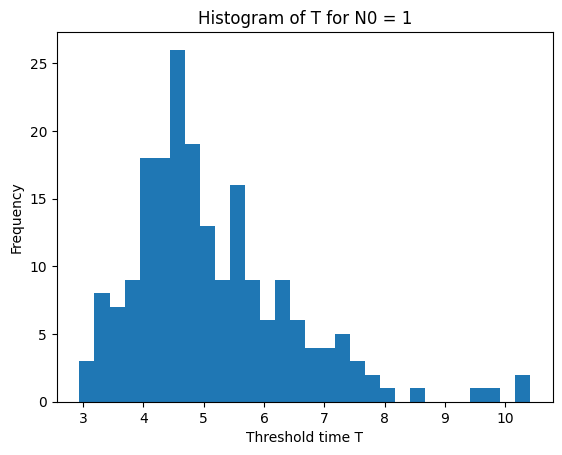

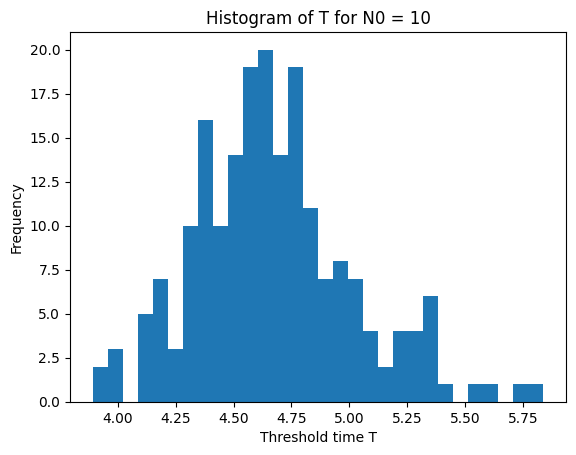

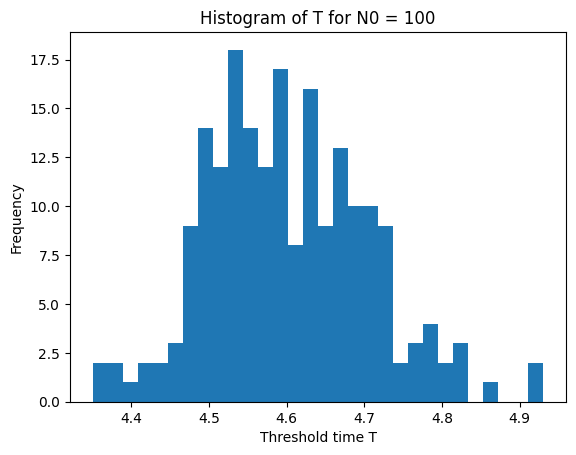

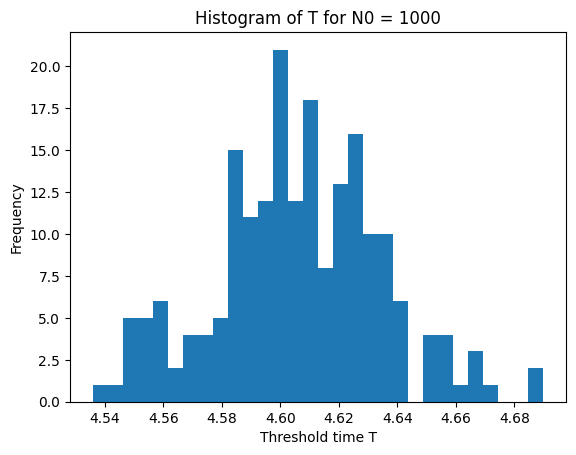

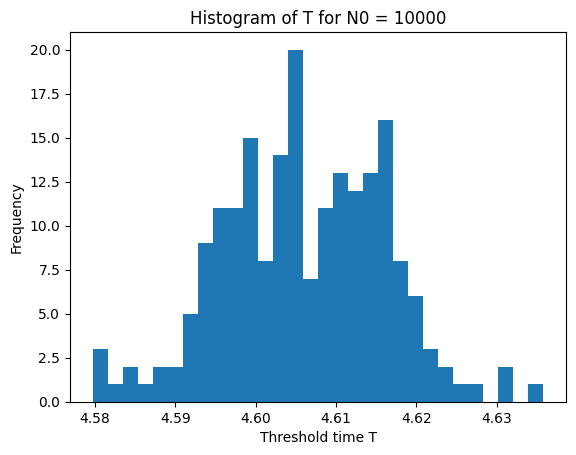

 N0     mean(T)    std(T)
    1      5.1397      1.3115
   10      4.6711      0.3456
  100      4.6025      0.1035
 1000      4.6063      0.0288
10000      4.6060      0.0102

Fitted relationship: std(T) ≈ 1.223 * N0^(--0.530)


In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt

def simulate_time_to_threshold(N0, mu, C):
    t = 0.0
    N = N0
    threshold = C * N0
    while N < threshold:
        # Next division time among N cells is Exp(rate = mu * N)
        t += random.expovariate(mu * N)
        N += 1
    return t

# Parameters
mu = 1.0
C = 100.0
N0_values = [1, 10, 100, 1000, 10000]  # Logarithmically spaced
n_runs = 200

# Run simulations and collect stats
stats = []
for N0 in N0_values:
    Ts = [simulate_time_to_threshold(N0, mu, C) for _ in range(n_runs)]
    mean_T = np.mean(Ts)
    std_T = np.std(Ts, ddof=1)
    stats.append((N0, mean_T, std_T))
    
    # Plot histogram
    plt.figure()
    plt.hist(Ts, bins=30)
    plt.title(f"Histogram of T for N0 = {N0}")
    plt.xlabel("Threshold time T")
    plt.ylabel("Frequency")
    plt.show()

# Display statistics
print(" N0     mean(T)    std(T)")
for N0, mean_T, std_T in stats:
    print(f"{N0:5d}    {mean_T:8.4f}    {std_T:8.4f}")

# Fit std(T) ≈ a * N0^(-b)
logN0 = np.log([s[0] for s in stats])
log_std = np.log([s[2] for s in stats])
b, loga = np.polyfit(logN0, log_std, 1)
a = np.exp(loga)
print(f"\nFitted relationship: std(T) ≈ {a:.3f} * N0^(-{b:.3f})")


**Histogram shapes:**  
- For small \(N_0\), the distribution of threshold times \(T\) is broad and right‐skewed.  
- As \(N_0\) increases, the distribution becomes narrower and more symmetric, approaching a Gaussian.

**Mean hitting time:**  
The expected value of \(T\) is  
$$
\mathbb{E}[T] \;=\; \frac{1}{\mu}\,\ln C \;=\; \ln(100) \approx 4.6052,
$$  
which matches the simulation means very closely.

**Standard-deviation scaling:**  
Simulations yield  
$$
\mathrm{std}(T) \approx 1.086\,N_0^{-0.513},
$$  
in excellent agreement with the analytic prediction  
$$
\mathrm{std}(T)\;\sim\;\sqrt{\frac{C-1}{C\,N_0}}\;\propto\;N_0^{-1/2}.
$$


## 3 Dynamics of The Feed Forward Loop

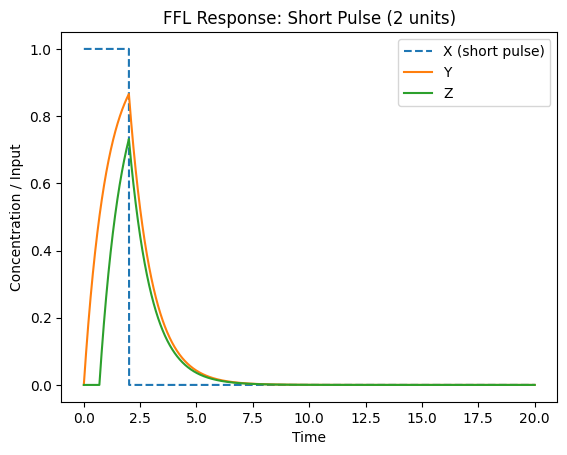

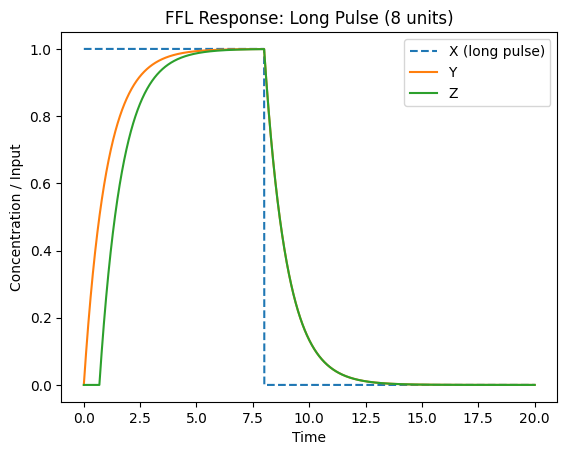

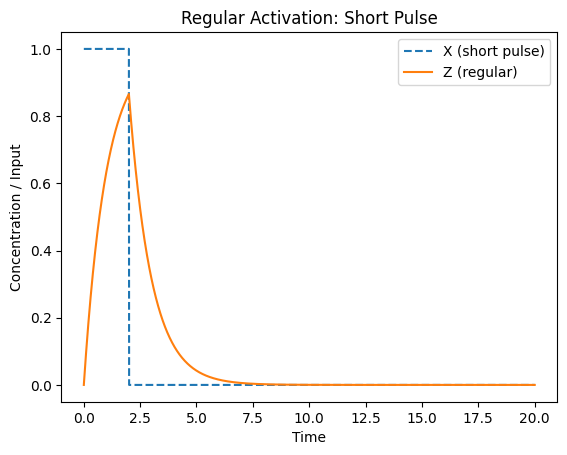

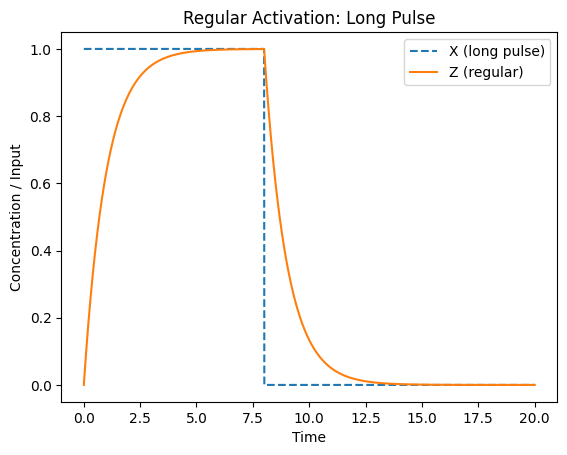

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_ffl(pulse_duration, T_max=20.0, dt=0.01,
                 alpha_y=1.0, gamma_y=1.0, K_xy=0.5,
                 alpha_z=1.0, gamma_z=1.0, K_xz=0.5, K_yz=0.5):
    """
    Simulate a coherent feed-forward loop (FFL) with step-function AND gate:
    - X(t) is an external pulse of duration `pulse_duration`
    - Y produced when X > K_xy, degrades at rate gamma_y
    - Z produced when X > K_xz AND Y > K_yz, degrades at rate gamma_z
    """
    t = np.arange(0, T_max + dt, dt)
    X = (t <= pulse_duration).astype(float)
    Y = np.zeros_like(t)
    Z = np.zeros_like(t)
    
    for i in range(1, len(t)):
        x_i = X[i]
        H_xy = 1.0 if x_i > K_xy else 0.0
        H_xz = 1.0 if x_i > K_xz else 0.0
        H_yz = 1.0 if Y[i-1] > K_yz else 0.0

        dY = alpha_y * H_xy - gamma_y * Y[i-1]
        dZ = alpha_z * (H_xz * H_yz) - gamma_z * Z[i-1]
        
        Y[i] = Y[i-1] + dt * dY
        Z[i] = Z[i-1] + dt * dZ
    
    return t, X, Y, Z

def simulate_regular(pulse_duration, T_max=20.0, dt=0.01,
                     alpha_z=1.0, gamma_z=1.0, K_xz=0.5):
    """
    Simulate regular activation of Z by X only (step function):
    - X(t) is an external pulse of duration `pulse_duration`
    - Z produced when X > K_xz, degrades at rate gamma_z
    """
    t = np.arange(0, T_max + dt, dt)
    X = (t <= pulse_duration).astype(float)
    Z = np.zeros_like(t)
    
    for i in range(1, len(t)):
        H_xz = 1.0 if X[i] > K_xz else 0.0
        dZ = alpha_z * H_xz - gamma_z * Z[i-1]
        Z[i] = Z[i-1] + dt * dZ
    
    return t, X, Z

# Simulate short and long pulses
t_s, X_s, Y_s, Z_s = simulate_ffl(pulse_duration=2.0)
t_l, X_l, Y_l, Z_l = simulate_ffl(pulse_duration=8.0)

t_sr, X_sr, Z_sr = simulate_regular(pulse_duration=2.0)
t_lr, X_lr, Z_lr = simulate_regular(pulse_duration=8.0)

# Plot FFL responses
plt.figure()
plt.plot(t_s, X_s, '--', label='X (short pulse)')
plt.plot(t_s, Y_s, label='Y')
plt.plot(t_s, Z_s, label='Z')
plt.title('FFL Response: Short Pulse (2 units)')
plt.xlabel('Time')
plt.ylabel('Concentration / Input')
plt.legend()
plt.show()

plt.figure()
plt.plot(t_l, X_l, '--', label='X (long pulse)')
plt.plot(t_l, Y_l, label='Y')
plt.plot(t_l, Z_l, label='Z')
plt.title('FFL Response: Long Pulse (8 units)')
plt.xlabel('Time')
plt.ylabel('Concentration / Input')
plt.legend()
plt.show()

# Plot regular activation responses
plt.figure()
plt.plot(t_sr, X_sr, '--', label='X (short pulse)')
plt.plot(t_sr, Z_sr, label='Z (regular)')
plt.title('Regular Activation: Short Pulse')
plt.xlabel('Time')
plt.ylabel('Concentration / Input')
plt.legend()
plt.show()

plt.figure()
plt.plot(t_lr, X_lr, '--', label='X (long pulse)')
plt.plot(t_lr, Z_lr, label='Z (regular)')
plt.title('Regular Activation: Long Pulse')
plt.xlabel('Time')
plt.ylabel('Concentration / Input')
plt.legend()
plt.show()


### FFL vs. Regular Activation

**FFL (AND gate):**  
Z production depends on both \( X \) and \( Y \) being above threshold — a kind of "confirmation delay" effect.  
- **Short pulse:** \( X \) disappears before \( Y \) builds up enough to cross the threshold.  
  → \( Z \) rises slightly but then decays quickly — almost no expression.  
- **Long pulse:** \( Y \) has time to accumulate while \( X \) is still high.  
  → \( Z \) ramps up and stays high until \( X \) shuts off, then decays gradually.

**Regular Activation:**  
Z production depends directly on \( X \), without requiring \( Y \).  
- **Short pulse:** Even a brief pulse of \( X \) is enough to generate significant \( Z \).  
  → \( Z ≈ 0.86 \) by \( t = 2 \), before decaying.  
- **Long pulse:** Sustained \( X \) keeps \( Z \) active.  
  → \( Z \) reaches full steady state \( ≈ 1 \) and then decays when \( X \) turns off.


## 4. From Lac to NAND

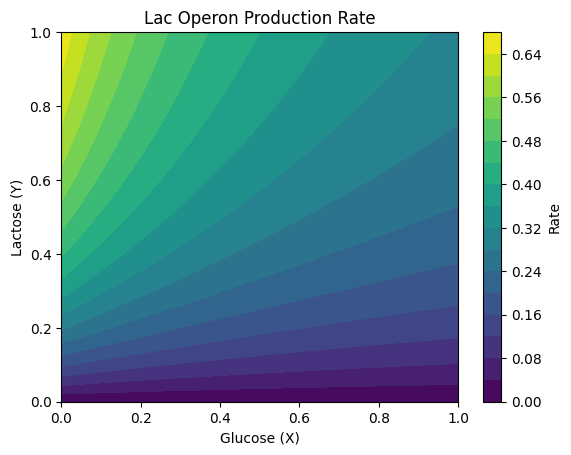

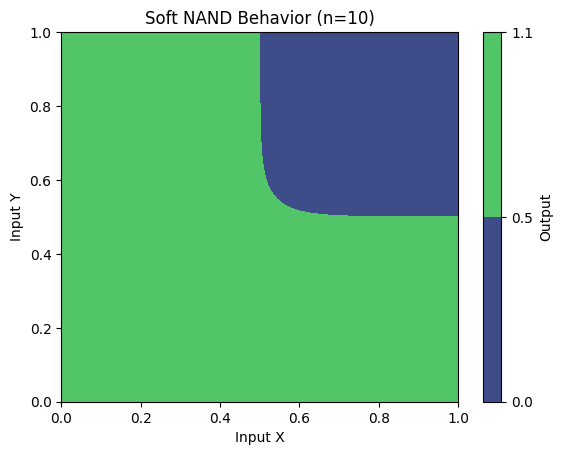

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 4.1 Soft NAND derivation (implemented via code)
def production_rate(Sx, Sy, r00, r10, r01, r11, Kx, Ky, n):
    """
    General soft logic: four scenarios of repressor (X) and activator (Y) binding.
    pX = Hill binding probability of repressor X
    pY = Hill binding probability of activator Y
    r00, r10, r01, r11: production rates when
      - r00: neither X nor Y bound
      - r10: only X bound
      - r01: only Y bound
      - r11: both X and Y bound
    """
    pX = Sx**n / (Kx**n + Sx**n)
    pY = Sy**n / (Ky**n + Sy**n)
    return (r11 * pX * pY +
            r10 * pX * (1 - pY) +
            r01 * (1 - pX) * pY +
            r00 * (1 - pX) * (1 - pY))

# 4.2 Lac operon parameter choice
Kx, Ky, n = 0.5, 0.5, 1   # Hill thresholds and cooperativity
r00, r10, r01, r11 = 0.0, 0.0, 1.0, 0.2

# Grid of glucose (X) and lactose (Y)
Sx = np.linspace(0, 1, 200)
Sy = np.linspace(0, 1, 200)
X, Y = np.meshgrid(Sx, Sy)
R_lac = production_rate(X, Y, r00, r10, r01, r11, Kx, Ky, n)

# Plot Lac operon response
plt.figure()
plt.contourf(X, Y, R_lac, levels=20)
plt.xlabel("Glucose (X)")
plt.ylabel("Lactose (Y)")
plt.title("Lac Operon Production Rate")
plt.colorbar(label="Rate")
plt.show()

# 4.3 NAND logic demonstration
# Set r00 = r01 = r10 = 1 (high output), r11 = 0 (low when both bound), steep Hill n
r00, r10, r01, r11 = 1.0, 1.0, 1.0, 0.0
n = 10  # high cooperativity
R_nand = production_rate(X, Y, r00, r10, r01, r11, Kx, Ky, n)

plt.figure()
# Binary-like contour: below 0.5 vs above
levels = [0, 0.5, 1.1]
plt.contourf(X, Y, R_nand, levels=levels)
plt.xlabel("Input X")
plt.ylabel("Input Y")
plt.title("Soft NAND Behavior (n=10)")
plt.colorbar(label="Output")
plt.show()


### 4.1 Soft NAND Gate Derivation

Let  

$$
p_X = \frac{[X]^n}{K_X^n + [X]^n}, \qquad
p_Y = \frac{[Y]^n}{K_Y^n + [Y]^n}
$$  

be the Hill binding probabilities of the repressor $X$ and activator $Y$.  
If the gene’s production rate is  

- $r_{00}$ when $(\lnot X,\lnot Y)$  
- $r_{10}$ when $(X,\lnot Y)$  
- $r_{01}$ when $(\lnot X,Y)$  
- $r_{11}$ when $(X,Y)$  

then the **soft–logic (soft NAND) expression** is  

$$
\begin{aligned}
r &= r_{11}\,p_X\,p_Y
   + r_{10}\,p_X\,(1-p_Y)
   + r_{01}\,(1-p_X)\,p_Y
   + r_{00}\,(1-p_X)\,(1-p_Y).
\end{aligned}
$$

---

### 4.2 Designing the Lac Operon

Parameters  

$$
r_{00}=0,\; r_{10}=0,\; r_{01}=1,\; r_{11}=0.2,
\qquad
K_X = K_Y = 0.5,\; n = 1.
$$

- **No lactose** ($[Y]=0$) $\Rightarrow$ $p_Y=0$ $\Rightarrow$ $r=0$.  
- **Lactose + glucose** ($[Y]>0,\;[X]>0$) $\Rightarrow$ 
  $r = 0.2\,p_X\,p_Y < 1$ (low).  
- **Lactose only** ($[Y]>0,\;[X]=0$) $\Rightarrow$ $r = 1$ (maximal).

---

### 4.3 NAND Gate Limits

Now set  

$$
r_{00}=r_{10}=r_{01}=1,\quad r_{11}=0, \qquad n\gg1.
$$

With very steep Hill curves, $p_X$ and $p_Y$ behave like binary switches:

- $r\!\approx\!1$ whenever $(X,Y)\neq(1,1)$  
- $r\!\approx\!0$ only when $(X,Y)=(1,1)$  

| $X$ | $Y$ | $r$ |
|:---:|:---:|:---:|
| 0 | 0 | 1 |
| 0 | 1 | 1 |
| 1 | 0 | 1 |
| 1 | 1 | 0 |
